Modulo predictor - Notebook

In [1]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 6.5 MB/s 
     |████████████████████████████████| 76 kB 5.6 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0


In [36]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Graficos
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Liberia para descargar archivos
import io
import urllib.request

from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

# Configuracion warnings
import warnings
warnings.filterwarnings('ignore')

In [57]:
def getYesterdayEpoch():
  d = date.today() - timedelta(days=1)
  return str(datetime(d.year, d.month, d.day).timestamp()).replace('.0', '')

In [38]:
def downloadFile(url):
  with urllib.request.urlopen(url) as f:
      response = f.read().decode('utf-8')
  datos = pd.read_csv(io.StringIO(response))
  datos = datos.set_index("Date")
  return datos

In [39]:
def printStartAndDate(datos):
  print(f"Fecha inicio datos: {datos.index.min()}")
  print(f"Fecha fin datos: {datos.index.max()}")

In [66]:
def getLimitDates(datos):
  startDate = datos.index.min()
  endDate = datos.index.max()

  startTestDate = datetime.now() - relativedelta(months = 6) # Hace 6 meses
  startValidationDate = startTestDate - relativedelta(years = 1) # Hace 1 año y 6 meses

  # Se toman como limites desde que existen registros a la fecha de hace 1 año y 6 meses
  trainStartDate = startDate
  trainEndDate = (startValidationDate - relativedelta(days = 1)).strftime('%Y-%m-%d')

  # Se usa 1 año de datos de hace 1 año y 6 meses
  validationStartDate = startValidationDate.strftime('%Y-%m-%d')
  validationEndDate = (startTestDate - relativedelta(days = 1)).strftime('%Y-%m-%d')

  # Se usan los ultimos 6 meses
  testStartDate = startTestDate.strftime('%Y-%m-%d')
  testEndDate = endDate

  return [
      trainStartDate,
      trainEndDate,
      validationStartDate,
      validationEndDate,
      testStartDate,
      testEndDate
  ]

In [58]:
# url para decargar los registros de Yahoo Finance, la fecha inicial es 2014-09-17 y la fecha final es el dia de hoy menos un dia (ayer)
btc_url = 'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410825600&period2=' + getYesterdayEpoch() + '&interval=1d&events=history&includeAdjustedClose=true'

In [61]:
# Descarga de datos
datos = downloadFile(btc_url);
datos.info()
datos.head()
printStartAndDate(datos)

<class 'pandas.core.frame.DataFrame'>
Index: 2900 entries, 2014-09-17 to 2022-08-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2899 non-null   float64
 1   High       2899 non-null   float64
 2   Low        2899 non-null   float64
 3   Close      2899 non-null   float64
 4   Adj Close  2899 non-null   float64
 5   Volume     2899 non-null   float64
dtypes: float64(6)
memory usage: 158.6+ KB
Fecha inicio datos: 2014-09-17
Fecha fin datos: 2022-08-25


In [69]:
# Separacion datos entrenamiento-validacion-test
# El dataset que tenemos contempla informacion desde el 2014-09-17 hasta el dia de ayer
dates = getLimitDates(datos)

datos = datos.loc[dates[0] : dates[5]]
datos_train = datos.loc[: dates[1] :] # Del 2014-09-17 hasta hace 1 año y 6 meses
datos_val = datos.loc[dates[2] : dates[3], :] # 1 año
datos_test = datos.loc[ dates[4] : , ] # 6 meses

print(f"Fechas entrenamiento      : {datos_train.index.min()} ... {datos_train.index.max()} (n={len(datos_train)})")
print(f"Fechas validacion         : {datos_val.index.min()} ... {datos_val.index.max()} (n={len(datos_val)})")
print(f"Fechas test               : {datos_test.index.min()} ... {datos_test.index.max()} (n={len(datos_test)})")

Fechas entrenamiento      : 2014-09-17 ... 2021-02-25 (n=2354)
Fechas validacion         : 2021-02-26 ... 2022-02-25 (n=365)
Fechas test               : 2022-02-26 ... 2022-08-25 (n=181)


# Exploracion gráfica

## Serie temporal

In [70]:
# Funcion para mostrar grafico
# - dataFrame debe de ser una tupla, donde el primer elemento es el dataFrame y 
# y el segundo es la etiqueta de se dataFrame
# - title es el titulo del grafico
def showPlot(dataFrames, title):
  fig, ax = plt.subplots(figsize=(20,8))
  for frame in dataFrames:
    plt.plot(frame[0].index, frame[0].High, label=frame[1] + " - High")
    plt.plot(frame[0].index, frame[0].Low, label=frame[1] + " - Low")

  ax.set_title(title)
  ax.legend()
  plt.show()

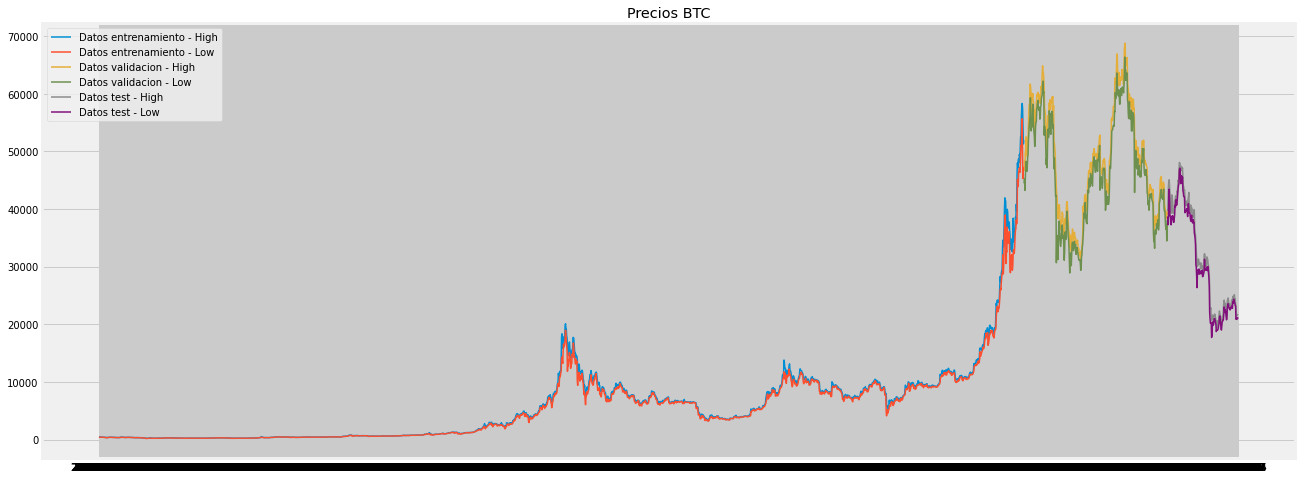

In [71]:
# Grafico de la serie temporal
showPlot([(datos_train, 'Datos entrenamiento'), (datos_val, 'Datos validacion'), (datos_test, 'Datos test')], 'Precios BTC')

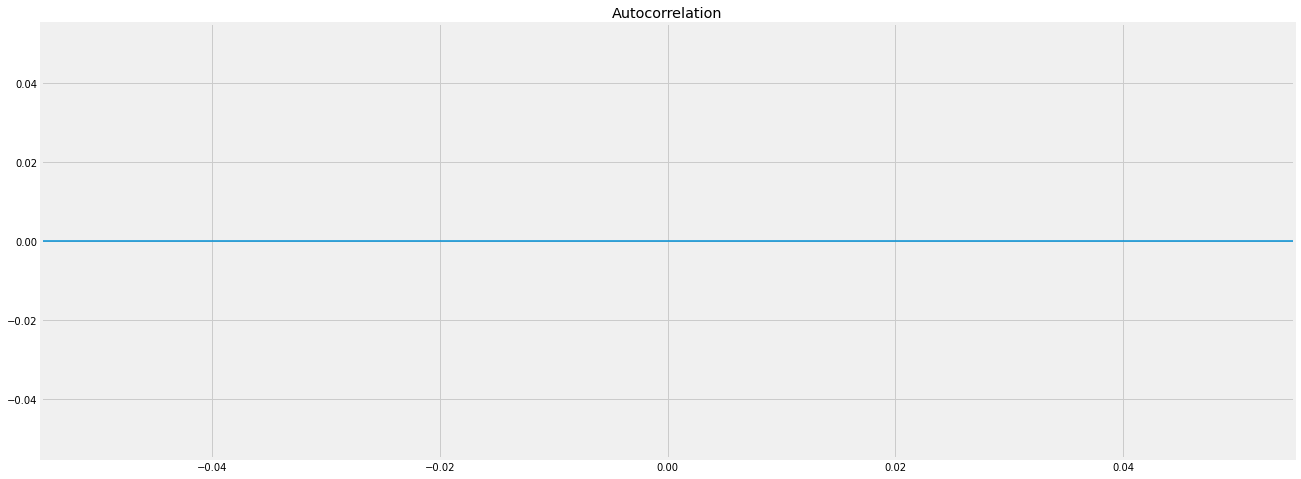

In [72]:
# Grafico autocorrelacion
fig, ax = plt.subplots(figsize=(20,8))
plot_acf(datos.High, ax=ax, lags=72)
plt.show()